# Lab 8

- Daniel Alfredo Rayo Roldan
- Flavio Galan
- Maria Fernanda
- Irving Fabricio

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Análisis exploratorio

Para este reporte se esta trabajandon registros de ventas hechas en para diferentes articulos, en diferentes sucursales, el objetivo es poder desarrollar un modelo temporal que pueda predecir las ventas para los diferentes articulos, para ello una comprensión de los datos con lo que se trabajó fue importante.

In [2]:
df = pd.read_csv("./data/train.csv")

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['date', 'store', 'item']).reset_index(drop=True)

Un primer acercamiento nos indica que estamos trabajando con un dataset de 4 variables y 913,000 registros:

- `date`: Fecha en que se registren las ventas.
- `store`: ID de la tienda en que se hicieron las ventas.
- `item`: ID del item del que se registro ventas.
- `sales`: Cantidad de articulos vendidos.

In [3]:
print("Dimensiones del dataframe:", df.shape)
print("\nPrimeras filas:")
print(df.head())

Dimensiones del dataframe: (913000, 4)

Primeras filas:
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-01      1     2     33
2 2013-01-01      1     3     15
3 2013-01-01      1     4     10
4 2013-01-01      1     5     11


Se pudo observar que todos las variables que las primeras 3 variables son categóricas aunque representadas númericamente en pandas.

In [4]:
print("\nInformacion de Data:")
print(df.info())


Informacion de Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


Se cuentan con registros desde el 1 de enero de 203 hasta el 31 de diciembre de 2017 que comprende los datos de 10 articulos y 50 tiendas.

In [5]:
print("\nRango de Fechas:", df['date'].min(), "to", df['date'].max())
print("\nNumero de tiendas:", df['store'].nunique())
print("\nNumero de items:", df['item'].nunique())


Rango de Fechas: 2013-01-01 00:00:00 to 2017-12-31 00:00:00

Numero de tiendas: 10

Numero de items: 50


Además parece que la cantidad de datos esta balanceada para cada combinacion de tiendas y artículos, garantizando que el modelo no beneficiara más unos patrones que otros.

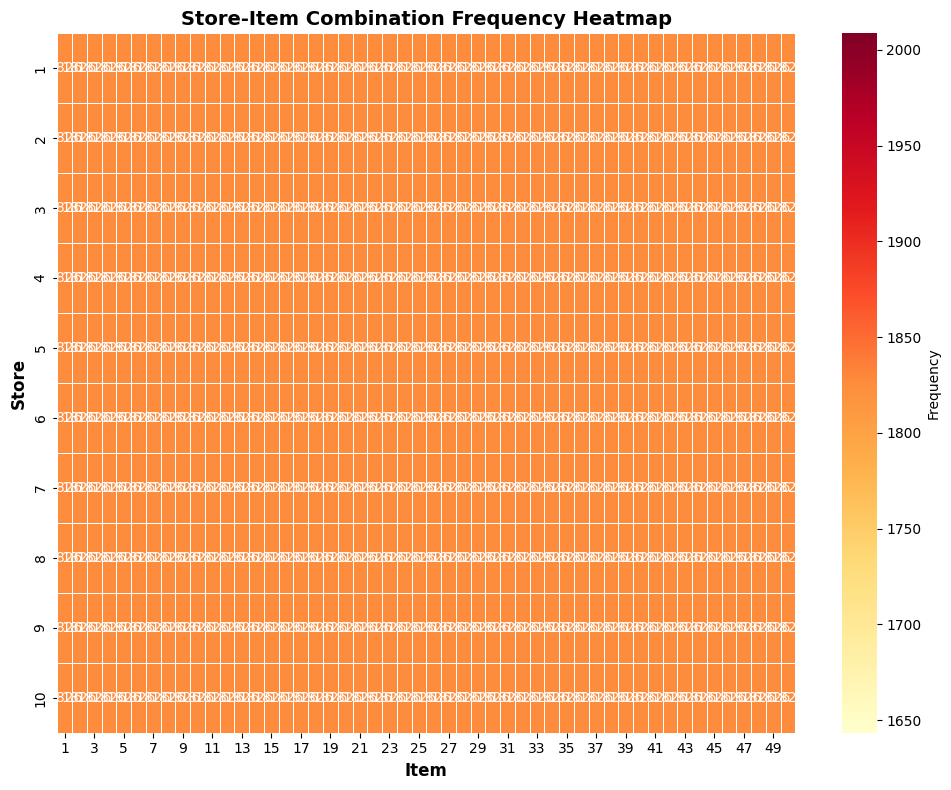

In [6]:
def plot_store_item_heatmap(df, figsize=(10, 8)):
    # Count frequency for each combination
    freq_matrix = df.groupby(['store', 'item']).size().unstack(fill_value=0)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(freq_matrix, annot=True, fmt='d', cmap='YlOrRd',
                linewidths=0.5, cbar_kws={'label': 'Frequency'})

    plt.xlabel('Item', fontsize=12, fontweight='bold')
    plt.ylabel('Store', fontsize=12, fontweight='bold')
    plt.title('Store-Item Combination Frequency Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
plot_store_item_heatmap(df)

Por último y muy importante, no parece haber datos nulos en ninguno de los registros.

In [7]:
print("Valores nulos")
df.isna().sum()

Valores nulos


,0
date,0
store,0
item,0
sales,0


In [8]:
duplicates = df.duplicated(subset=['date', 'store', 'item'])
print(f"\nFilas duplicadas: {duplicates.sum()}")


Filas duplicadas: 0


# Limpieza de datos

Para la limpieza de datos, dado que se corroboro que no habian datos nulos o vacios, la única preocupación era que pudieran no haber fechas registradas para alguno articulo y tienda, así que las fechas vacios fueron llenas con la combinación e indicando que ese día se hicieron 0 ventas.

In [9]:
min_date = df['date'].min()
max_date = df['date'].max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

stores = df['store'].unique()
items = df['item'].unique()

complete_index = pd.MultiIndex.from_product(
    [all_dates, stores, items],
    names=['date', 'store', 'item']
)
df_complete = pd.DataFrame(index=complete_index).reset_index()

df_complete = df_complete.merge(df, on=['date', 'store', 'item'], how='left')

In [10]:
def plot_item_all_stores(df, item_id, max_stores=10, figsize=(15, 10)):
    # Filter data for the item
    item_data = df[df['item'] == item_id]
    stores = sorted(item_data['store'].unique())[:max_stores]

    n_stores = len(stores)
    n_cols = 2
    n_rows = (n_stores + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_stores > 1 else [axes]

    for idx, store_id in enumerate(stores):
        data = item_data[item_data['store'] == store_id].sort_values('date')

        ax = axes[idx]
        ax.plot(data['date'], data['sales'], linewidth=1, alpha=0.7)

        # Add 7-day moving average
        rolling_mean = data['sales'].rolling(window=7, center=True).mean()
        ax.plot(data['date'], rolling_mean, linewidth=2, color='red', alpha=0.7)

        ax.set_title(f'Tienda {store_id}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=9)
        ax.set_ylabel('Ventas', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

    # Hide extra subplots
    for idx in range(n_stores, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'Todas las tiendas - Item {item_id}', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

Se pensaba en aplicar un diferenciación pero dado que no se presenta una tendencia muy fuerte, como se ve en las gráficas de abajo, además que se estará trabajando con redes neuronales se omitió la idea.

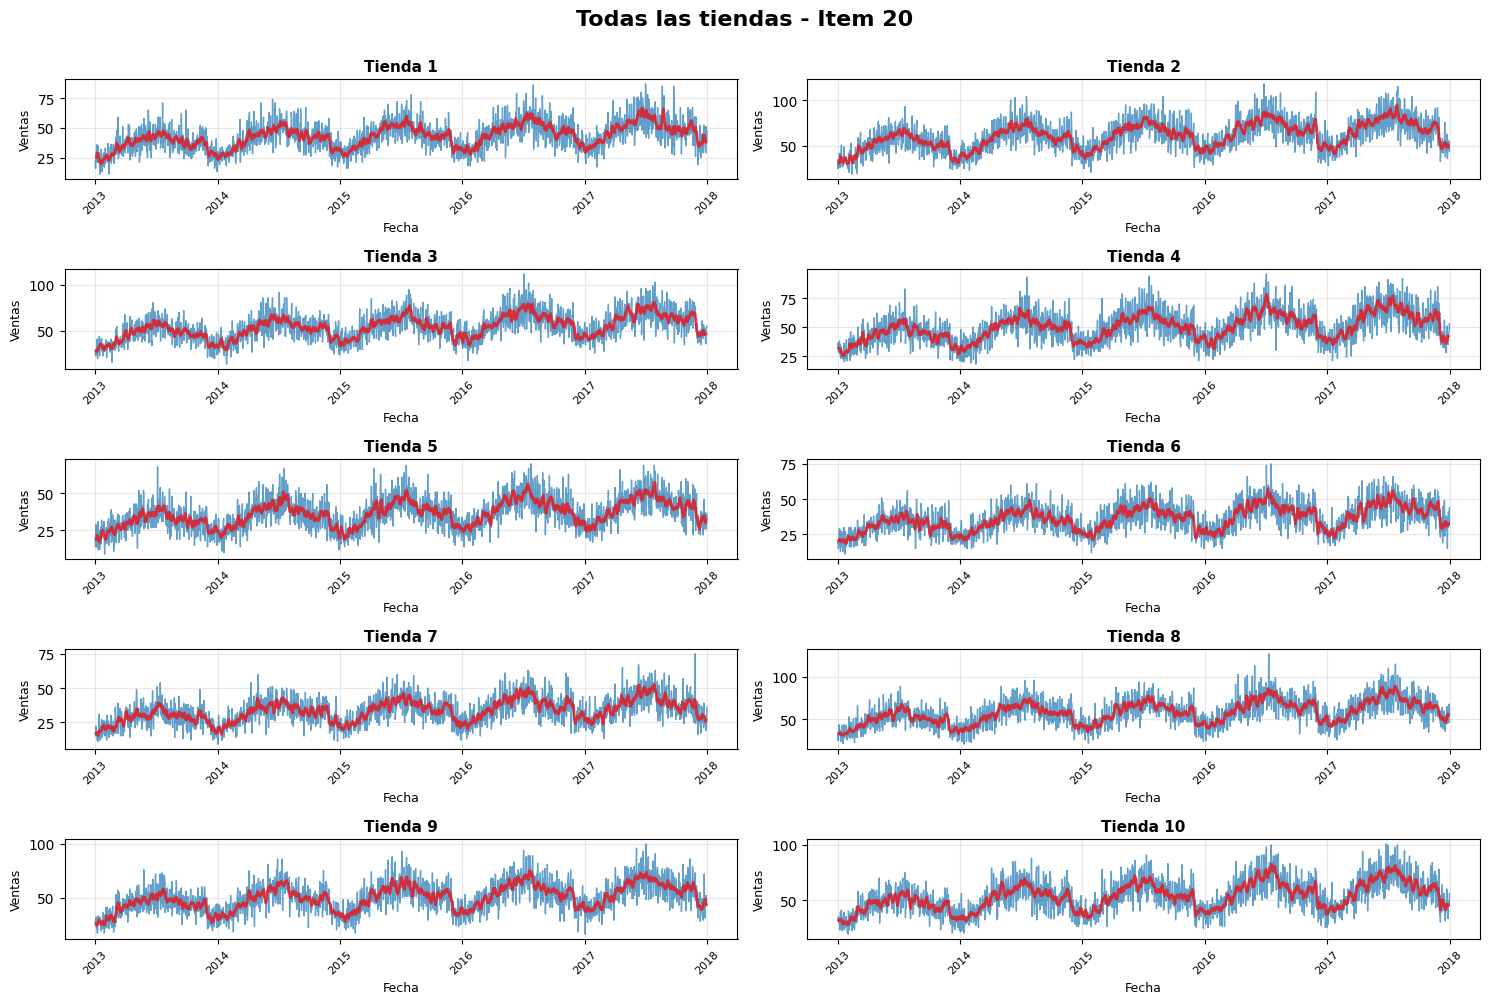

In [11]:
plot_item_all_stores(df_complete, 20)

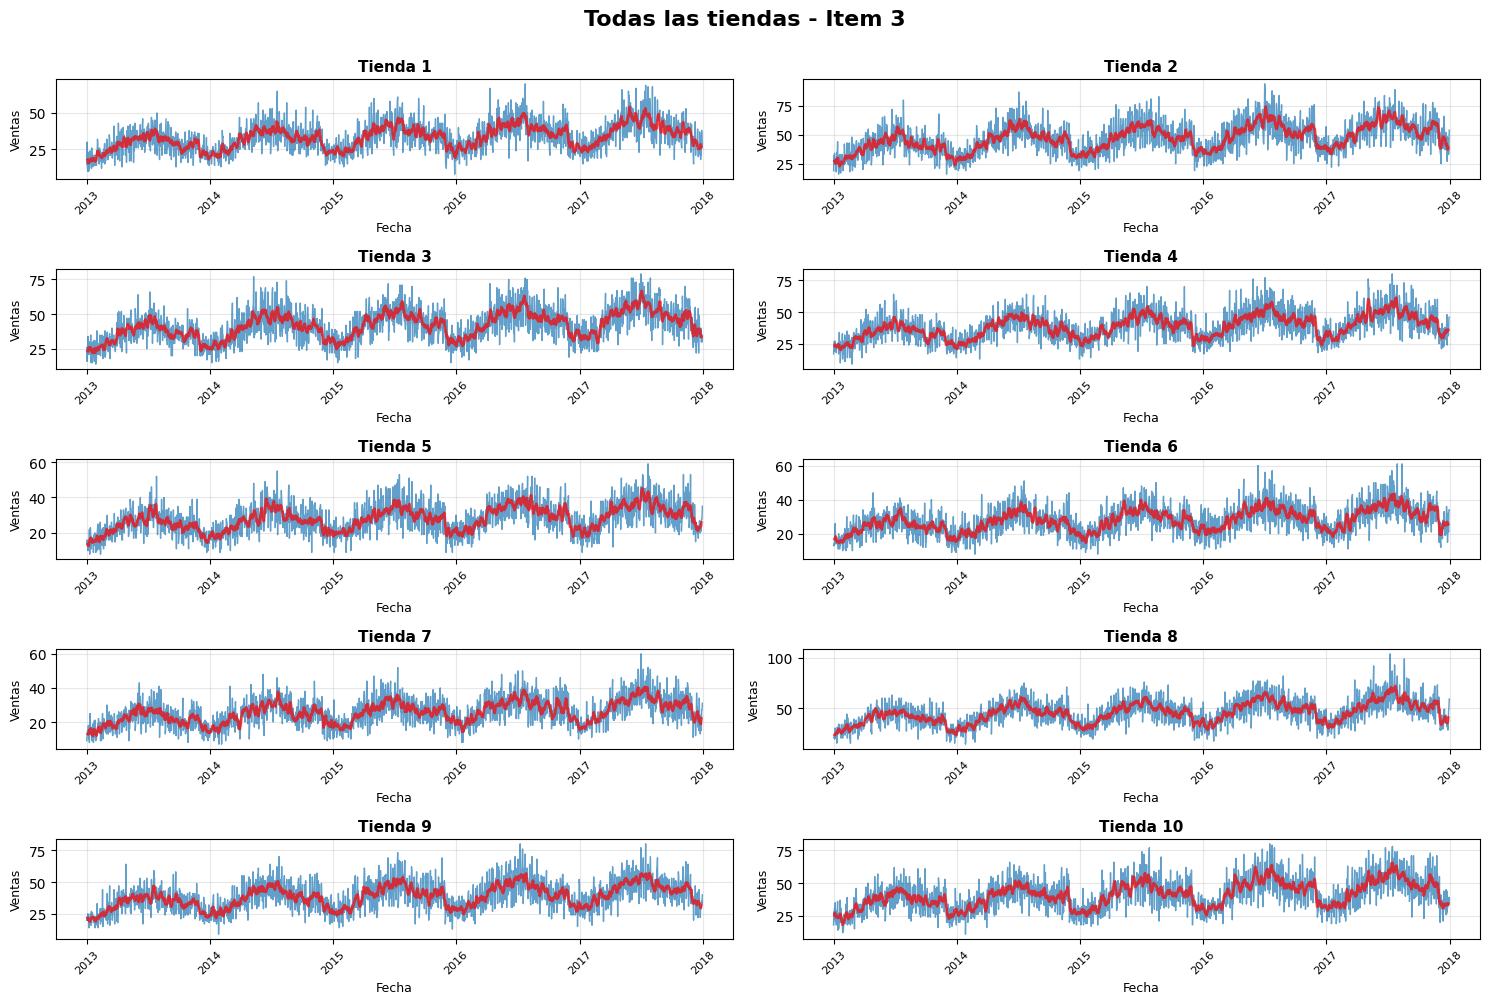

In [12]:
plot_item_all_stores(df_complete, 3)

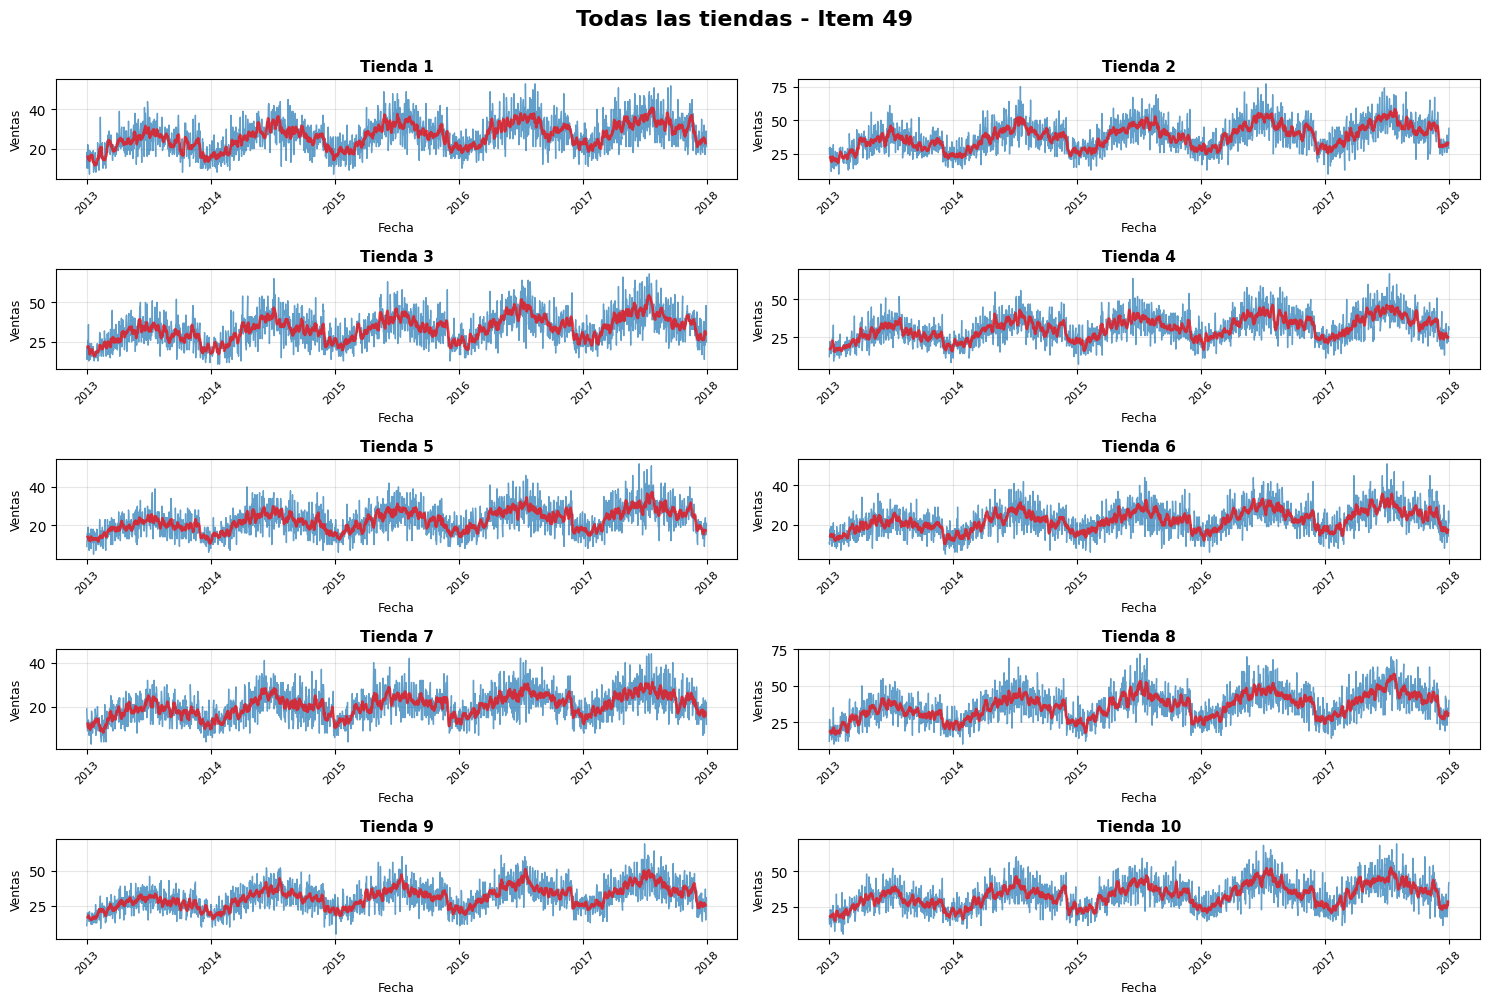

In [13]:
plot_item_all_stores(df_complete, 49)

## Modelo de Predicción

Tomando en cuenta los hallazgos del análisis exploratorio previo, se observo que todos los artículos presentaban serias temporal muy parecidas a lo largo de la fechas, además de presentar estacionalidad muy marcada, se decidió utilizar redes GRU (**Gated Recurrent Units**), al ser modelos más simples que los los LSTM y por requiriendo menos computo y tiempo de entrenamiento, siendo útiles cuando los datos no presentan comportamientos muy complejos.

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import multiprocessing

# Configuración de semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS
# ============================================================================


def load_and_prepare_data(filepath):
    """Carga y prepara los datos de ventas"""
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["store", "item", "date"])
    return df


def create_sequences(data, seq_length=60):
    """
    Crea secuencias temporales para el modelo GRU

    Args:
        data: Array con los datos de ventas
        seq_length: Longitud de la secuencia de entrada (días históricos)

    Returns:
        X: Secuencias de entrada
        y: Valores objetivo (siguiente punto)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def prepare_dataset(df, seq_length=60, forecast_horizon=90):
    """
    Prepara el dataset completo para todas las combinaciones store-item

    Args:
        df: DataFrame con los datos
        seq_length: Días históricos para predicción
        forecast_horizon: Días a predecir (3 meses = ~90 días)
    """
    scalers = {}
    X_all, y_all = [], []
    store_item_info = []

    # Procesar cada combinación de tienda e item
    for store in df["store"].unique():
        for item in df["item"].unique():
            # Filtrar datos para esta combinación
            mask = (df["store"] == store) & (df["item"] == item)
            sales_data = df[mask]["sales"].values.reshape(-1, 1)

            # Verificar que hay suficientes datos
            if len(sales_data) < seq_length + forecast_horizon:
                continue

            # Normalizar datos
            scaler = MinMaxScaler(feature_range=(0, 1))
            sales_scaled = scaler.fit_transform(sales_data)

            # Guardar scaler para desnormalización posterior
            scalers[(store, item)] = scaler

            # Crear secuencias
            X, y = create_sequences(sales_scaled, seq_length)

            X_all.append(X)
            y_all.append(y)
            store_item_info.extend([(store, item)] * len(X))

    X_all = np.vstack(X_all)
    y_all = np.vstack(y_all)

    return X_all, y_all, scalers, store_item_info


# ============================================================================
# 2. CONSTRUCCIÓN DEL MODELO GRU
# ============================================================================


def build_gru_model(seq_length, n_features=1):
    """
    Construye un modelo GRU para predicción de series temporales

    Arquitectura:
    - 2 capas GRU con dropout
    - Capas densas para la predicción final
    """
    model = keras.Sequential(
        [
            # Primera capa GRU
            layers.GRU(
                128,
                return_sequences=True,
                input_shape=(seq_length, n_features),
                activation="tanh",
            ),
            layers.Dropout(0.2),
            # Segunda capa GRU
            layers.GRU(64, return_sequences=False, activation="tanh"),
            layers.Dropout(0.2),
            # Capas densas
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(16, activation="relu"),
            layers.Dense(1),
        ]
    )

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"],
    )

    return model


# ============================================================================
# 3. ENTRENAMIENTO
# ============================================================================


def train_model(
    model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, patience=10
):
    """Entrena el modelo con callbacks"""

    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=0.00001
    )

    # Entrenamiento
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
    )

    return history


# ============================================================================
# 4. PREDICCIÓN DE 3 MESES
# ============================================================================


def predict_future(model, last_sequence, scaler, n_days=90):
    """
    Predice los próximos n_days usando predicción iterativa

    Args:
        model: Modelo GRU entrenado
        last_sequence: Última secuencia conocida (normalizada)
        scaler: Scaler para desnormalizar
        n_days: Número de días a predecir

    Returns:
        predictions: Array con las predicciones desnormalizadas
    """
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(n_days):
        # Predecir siguiente punto
        pred = model.predict(current_seq.reshape(1, -1, 1), verbose=0)
        predictions.append(pred[0, 0])

        # Actualizar secuencia (eliminar primer valor, agregar predicción)
        current_seq = np.append(current_seq[1:], pred[0, 0])

    # Desnormalizar predicciones
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions.flatten()

def predItem(model, df, scalers, seq_length, forecast_days, store, item):
    if (store,item) not in scalers:
        return pd.DataFrame()

    # Obtener últimos datos
    mask = (df["store"] == store) & (df["item"] == item)
    sales_data = df[mask]["sales"].values.reshape(-1, 1)

    # Normalizar
    scaler = scalers[(store, item)]
    sales_scaled = scaler.transform(sales_data)

    # Tomar última secuencia
    last_seq = sales_scaled[-seq_length:]

    # Predecir
    predictions = predict_future(model, last_seq, scaler, forecast_days)

    # Crear DataFrame con predicciones
    future_dates = [
        last_date + timedelta(days=i + 1) for i in range(forecast_days)
    ]

    pred_df = pd.DataFrame(
        {
            "date": future_dates,
            "store": store,
            "item": item,
            "predicted_sales": predictions,
        }
    )


def generate_all_predictions(model, df, scalers, seq_length=60, forecast_days=90, maxItems=50):
    """
    Genera predicciones para todas las combinaciones store-item

    Returns:
        DataFrame con las predicciones
    """
    all_predictions = []

    # Última fecha en los datos
    last_date = df["date"].max()

    uniqueStores = df["store"].unique()
    uniqueItems = df["item"].unique()

    for store in uniqueStores:
        print("Predicting store:", store, "of:", len(uniqueStores))
        for item in uniqueItems[:maxItems]:
            if (store, item) not in scalers:
                continue

            # Obtener últimos datos
            mask = (df['store'] == store) & (df['item'] == item)
            sales_data = df[mask]['sales'].values.reshape(-1, 1)

            # Normalizar
            scaler = scalers[(store, item)]
            sales_scaled = scaler.transform(sales_data)

            # Tomar última secuencia
            last_seq = sales_scaled[-seq_length:]

            # Predecir
            predictions = predict_future(model, last_seq, scaler, forecast_days)

            # Crear DataFrame con predicciones
            future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

            pred_df = pd.DataFrame({
                'date': future_dates,
                'store': store,
                'item': item,
                'predicted_sales': predictions
            })

            all_predictions.append(pred_df)
        # pred = pool.map(predItem,
        #                 [(model, df, scalers, seq_length, forecast_days, store, it) for it in uniqueItems[:maxItems]]
        # )
        # pred = pool.map(lambda item: predItem(model, df, scalers, seq_length, forecast_days, maxItems, store, item), uniqueItems[:maxItems])
        # all_predictions.extend(pred)

    return pd.concat(all_predictions, ignore_index=True)


# ============================================================================
# 5. VISUALIZACIÓN
# ============================================================================


def plot_predictions(df, predictions_df, store=1, item=1):
    """Visualiza predicciones para una combinación store-item"""

    # Datos históricos
    mask = (df["store"] == store) & (df["item"] == item)
    historical = df[mask].tail(180)  # Últimos 6 meses

    # Predicciones
    mask_pred = (predictions_df["store"] == store) & (predictions_df["item"] == item)
    future = predictions_df[mask_pred]

    plt.figure(figsize=(15, 6))
    plt.plot(
        historical["date"], historical["sales"], label="Ventas Históricas", linewidth=2
    )
    plt.plot(
        future["date"],
        future["predicted_sales"],
        label="Predicción 3 Meses",
        linewidth=2,
        linestyle="--",
        color="red",
    )

    plt.axvline(
        x=historical["date"].max(),
        color="green",
        linestyle=":",
        label="Inicio Predicción",
    )

    plt.title(f"Predicción de Ventas - Tienda {store}, Artículo {item}", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    """Visualiza el proceso de entrenamiento"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(history.history["loss"], label="Train Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Pérdida del Modelo")
    ax1.set_xlabel("Época")
    ax1.set_ylabel("MSE")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # MAE
    ax2.plot(history.history["mae"], label="Train MAE")
    ax2.plot(history.history["val_mae"], label="Validation MAE")
    ax2.set_title("Error Absoluto Medio")
    ax2.set_xlabel("Época")
    ax2.set_ylabel("MAE")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [15]:
# ============================================================================
# 6. PIPELINE COMPLETO
# ============================================================================
print("=" * 70)
print("MODELO GRU PARA PREDICCIÓN DE VENTAS")
print("=" * 70)

# Parámetros
SEQ_LENGTH = 60  # 2 meses de historia
FORECAST_DAYS = 90  # 3 meses de predicción

# 1. Cargar datos
print("\n1. Cargando datos...")
df = df_complete
print(f"   Datos cargados: {len(df)} registros")
print(f"   Tiendas: {df['store'].nunique()}, Artículos: {df['item'].nunique()}")
print(f"   Rango de fechas: {df['date'].min()} a {df['date'].max()}")

# 2. Preparar dataset
print("\n2. Preparando secuencias temporales...")
X, y, scalers, store_item_info = prepare_dataset(df, SEQ_LENGTH, FORECAST_DAYS)
print(f"   Secuencias creadas: {len(X)}")
print(f"   Forma de X: {X.shape}")

# 3. Split train/validation
print("\n3. Dividiendo datos...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"   Train: {len(X_train)}, Validation: {len(X_val)}")

MODELO GRU PARA PREDICCIÓN DE VENTAS

1. Cargando datos...
   Datos cargados: 913000 registros
   Tiendas: 10, Artículos: 50
   Rango de fechas: 2013-01-01 00:00:00 a 2017-12-31 00:00:00

2. Preparando secuencias temporales...
   Secuencias creadas: 883000
   Forma de X: (883000, 60, 1)

3. Dividiendo datos...
   Train: 706400, Validation: 176600



4. Construyendo modelo GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,337 (368.50 KB)

 Trainable params: 94,337 (368.50 KB)

 Non-trainable params: 0 (0.00 B)

None

5. Entrenando modelo...
Epoch 1/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 225s 10ms/step - loss: 0.0117 - mae: 0.0835 - val_loss: 0.0090 - val_mae: 0.0742 - learning_rate: 0.0010
Epoch 2/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 220s 10ms/step - loss: 0.0092 - mae: 0.0751 - val_loss: 0.0088 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 3/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 221s 10ms/step - loss: 0.0103 - mae: 0.0790 - val_loss: 0.0110 - val_mae: 0.0817 - learning_rate: 0.0010
Epoch 4/10
22075/22075 ━━━━━━━━━━━━━━━━━━━━ 222s 10ms/step - loss: 0.0109 - mae: 0.0816 - val_loss: 0.0102 - val_mae: 0.0788 - learning_rate: 0.0010

6. Visualizando resultados de entrenamiento...


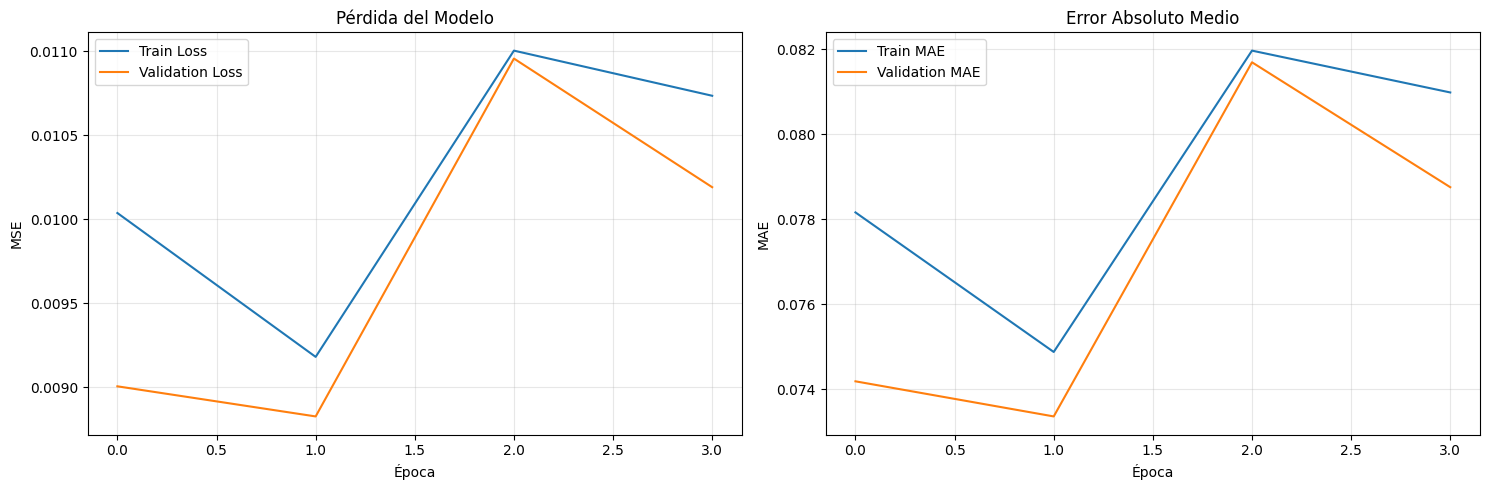

In [16]:
# 4. Construir modelo
print("\n4. Construyendo modelo GRU...")
model = build_gru_model(SEQ_LENGTH)
print(model.summary())

# 5. Entrenar
print("\n5. Entrenando modelo...")
history = train_model(model, X_train, y_train, X_val, y_val, epochs=10, patience=2)

# 6. Visualizar entrenamiento
print("\n6. Visualizando resultados de entrenamiento...")
plot_training_history(history)

In [19]:
# 7. Generar predicciones
print("\n7. Generando predicciones para 3 meses...")
maxItems = 10
predictions_df = generate_all_predictions(model, df, scalers, SEQ_LENGTH, FORECAST_DAYS, maxItems=maxItems)
print(f"   Predicciones generadas: {len(predictions_df)} registros")

# 8. Guardar predicciones
predictions_df.to_csv('predicciones_3_meses.csv', index=False)
print("\n8. Predicciones guardadas en 'predicciones_3_meses.csv'")


7. Generando predicciones para 3 meses...
Predicting store: 1 of: 10
Predicting store: 2 of: 10
Predicting store: 3 of: 10
Predicting store: 4 of: 10
Predicting store: 5 of: 10
Predicting store: 6 of: 10
Predicting store: 7 of: 10
Predicting store: 8 of: 10
Predicting store: 9 of: 10
Predicting store: 10 of: 10
   Predicciones generadas: 9000 registros

8. Predicciones guardadas en 'predicciones_3_meses.csv'



9. Visualizando ejemplos de predicciones...


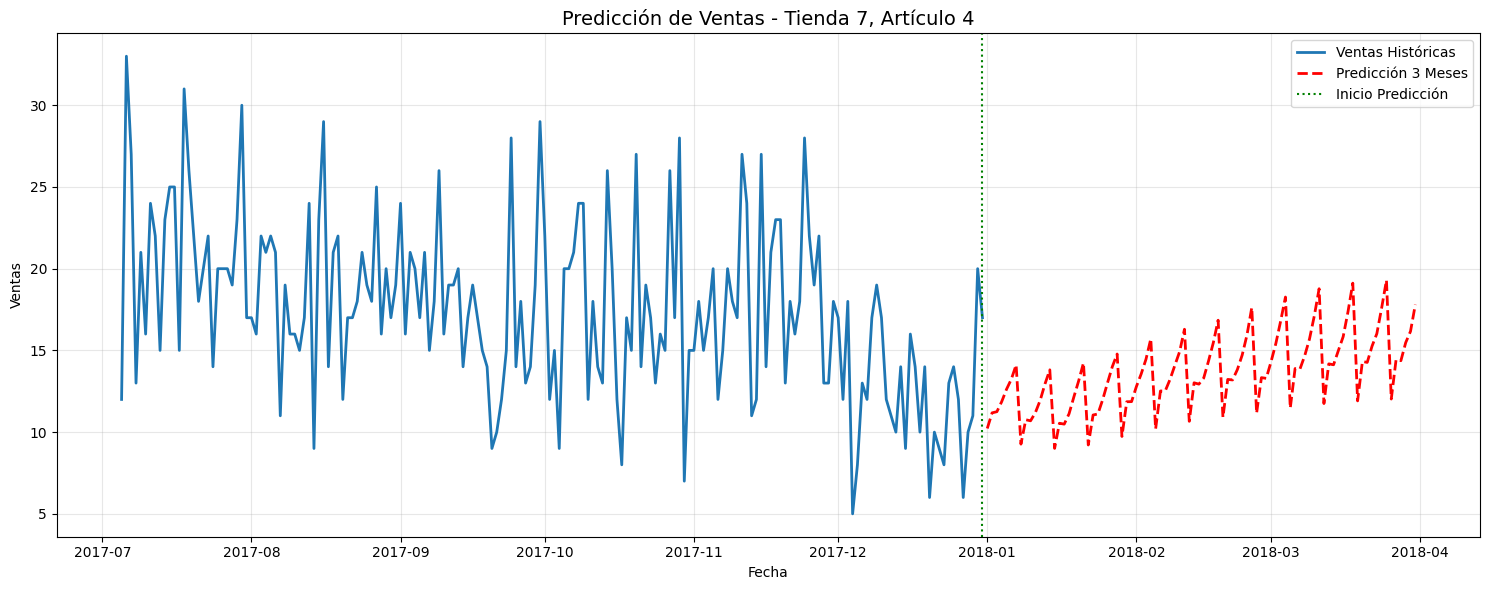

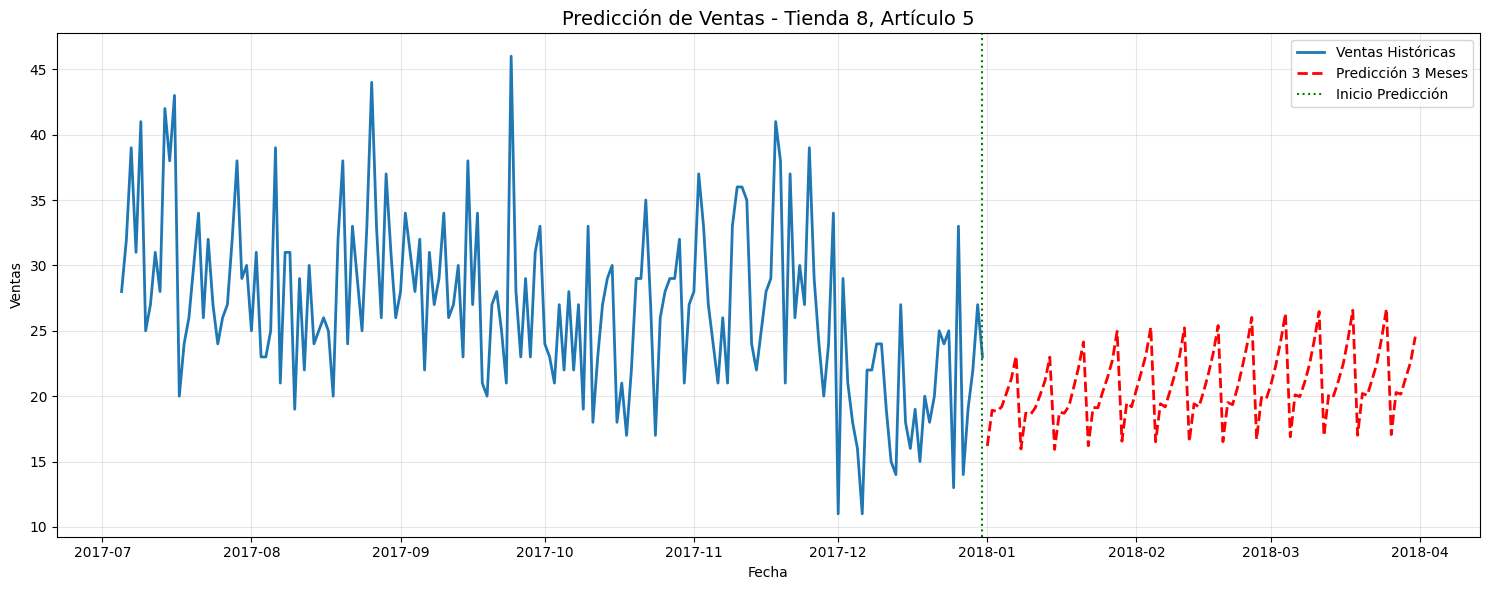

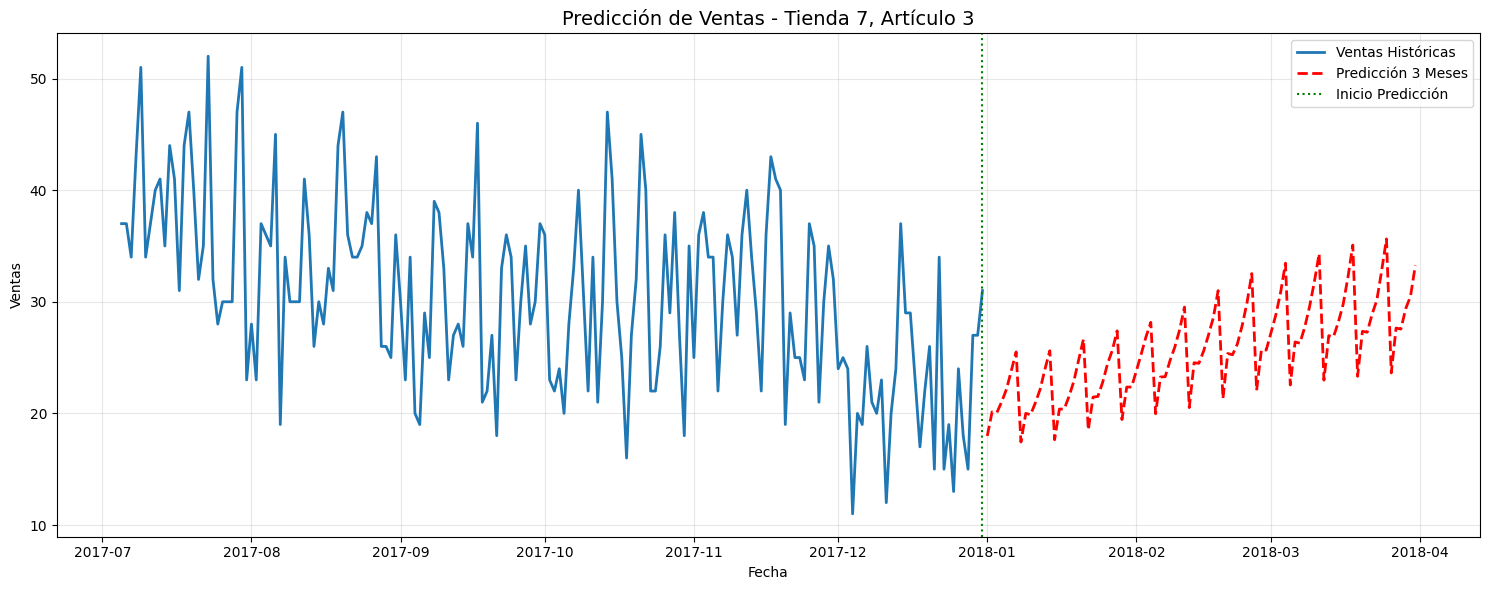

In [20]:
# 9. Visualizar ejemplos
print("\n9. Visualizando ejemplos de predicciones...")
for i in range(3):
    store = np.random.randint(1, 11)
    item = np.random.randint(1, maxItems)
    plot_predictions(df, predictions_df, store, item)